In [3]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from scipy import stats

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

## Open file and load data

In [5]:
# load csv file
original_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/herb flower data/Herbs_Fls_Summary.csv')

In [6]:
# create a copy of data
df = original_data.copy()

In [7]:
# view the first few entries of the data
df.head()

,Genus,Species,Site_ID,Site_Name,State,Year,First_Yes_DOY
0,Crocus,spp.,2,Home,ME,2011,86
1,Crocus,spp.,2,Home,ME,2012,69
2,Crocus,spp.,2,Home,ME,2013,72
3,Crocus,spp.,2,Home,ME,2014,103
4,Crocus,spp.,2,Home,ME,2015,98


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1902 entries, 0 to 1901
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Genus          1902 non-null   object
 1   Species        1902 non-null   object
 2   Site_ID        1902 non-null   int64 
 3   Site_Name      1902 non-null   object
 4   State          1902 non-null   object
 5   Year           1902 non-null   int64 
 6   First_Yes_DOY  1902 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 104.1+ KB


# Form groupings based on unique categorizations of location, specie, genus

In [9]:
# create a new column to capture the categories the entry pertains to
categories = []
for ind in df.index:
  category = (df['Site_Name'][ind], df['Species'][ind], df['Genus'][ind])
  categories.append(category)
df['categories'] = categories

In [10]:
# view the new column
df.head()

,Genus,Species,Site_ID,Site_Name,State,Year,First_Yes_DOY,categories
0,Crocus,spp.,2,Home,ME,2011,86,"(Home, spp., Crocus)"
1,Crocus,spp.,2,Home,ME,2012,69,"(Home, spp., Crocus)"
2,Crocus,spp.,2,Home,ME,2013,72,"(Home, spp., Crocus)"
3,Crocus,spp.,2,Home,ME,2014,103,"(Home, spp., Crocus)"
4,Crocus,spp.,2,Home,ME,2015,98,"(Home, spp., Crocus)"


In [11]:
category_list = df.categories.unique()
print('There are',len(category_list),'unique category groups')

There are 224 unique category groups


## Map each grouping to the subset of data that it consists of

In [12]:
# create hash map to map unique categories to the data points falling into those categories
categorized_data = {}

# for each category group observed in df, map the associated data to the category group
for category in category_list:
  filter1 = df["categories"]==(category[0],category[1],category[2])

  categorized_data.update({category:df.where(filter1, inplace = False).dropna()})

## Visualize and Example

In [13]:
# view data associated with a given category group
example_data = categorized_data.get(('Home', 'spp.', 'Crocus'))
# example_data = categorized_data.get(('Home', 'graminifolia', 'Euthamia'))
# (Vassar_College_Ecological_Preserve, capensis, Impatiens)

# you can look up different category groups by editing the above line of code, inside of the .get() function provide your categories as follows:
# ('Site','specie', 'genera')

# view data
example_data

,Genus,Species,Site_ID,Site_Name,State,Year,First_Yes_DOY,categories
0,Crocus,spp.,2.0,Home,ME,2011.0,86.0,"(Home, spp., Crocus)"
1,Crocus,spp.,2.0,Home,ME,2012.0,69.0,"(Home, spp., Crocus)"
2,Crocus,spp.,2.0,Home,ME,2013.0,72.0,"(Home, spp., Crocus)"
3,Crocus,spp.,2.0,Home,ME,2014.0,103.0,"(Home, spp., Crocus)"
4,Crocus,spp.,2.0,Home,ME,2015.0,98.0,"(Home, spp., Crocus)"
5,Crocus,spp.,2.0,Home,ME,2016.0,69.0,"(Home, spp., Crocus)"
6,Crocus,spp.,2.0,Home,ME,2017.0,64.0,"(Home, spp., Crocus)"
7,Crocus,spp.,2.0,Home,ME,2019.0,90.0,"(Home, spp., Crocus)"
8,Crocus,spp.,2.0,Home,ME,2020.0,69.0,"(Home, spp., Crocus)"
9,Crocus,spp.,2.0,Home,ME,2021.0,68.0,"(Home, spp., Crocus)"


## Now lets plot the example...

<Axes: xlabel='Year', ylabel='First_Yes_DOY'>

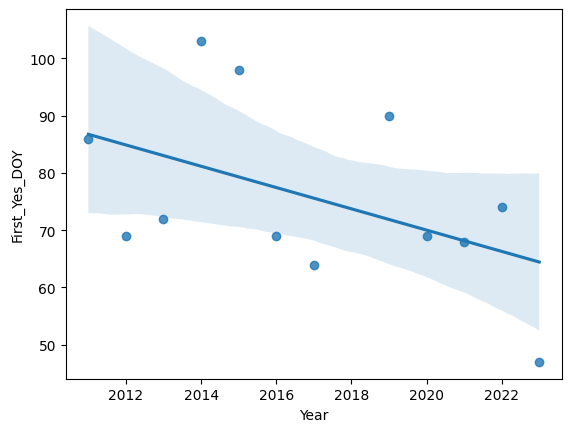

In [14]:
sns.regplot(example_data, x=example_data['Year'], y=example_data['First_Yes_DOY'])

## Now let's get the correlation coefficient

In [15]:
x=example_data['Year']
y=example_data['First_Yes_DOY']

round(x.corr(y),4)

-0.479

## Since there are 224 uique groupings, it doesn't make sense to visualize them all
## Let's just perform the regression, calculate some stats and store the results


In [17]:
#create a list of the various category groups and a separte list of their respective correlations
category_groups = []
pearson_correlations = []
kendall_taus = []
regression_scores = []
slopes=[]
p_values = []
results = []
results2 = []

# loop through all unique catgory groupings
for category in category_list:
  example_data = categorized_data.get((category[0],category[1],category[2]))
  x=example_data['Year']   #reshape x data to work with sklearn linear model
  y=example_data['First_Yes_DOY']
  correlation = round(x.corr(y),4)
  tau, p_value = stats.kendalltau(x, y)


  #run the regression via statsmodel
  x = sm.add_constant(x)
  est = sm.OLS(y,x)
  est2 = est.fit()
  if len(x) > 2:
    slopes.append(round(est2.params[1],4))
  else:
    slopes.append(pd.NA)

  p_values.append(round(est2.pvalues[0],4))
  regression_scores.append(round(est2.rsquared,4))

  category_groups.append(category)
  pearson_correlations.append(correlation)
  kendall_taus.append(round(tau,4))


correlation_df = pd.DataFrame({
    'grouping':category_groups,
    'Pearson r': pearson_correlations,
    'Kendall τ': kendall_taus,
    'slope':slopes,
    'R²' : regression_scores,
    'p-value':p_values
})


In [30]:
# drop all rows containing NaN values (these seem to usually result from instances where there is only one DOY observation)
correlation_df = correlation_df.dropna()

# view catergories & correlation
print(correlation_df.to_string())
print(len(correlation_df), 'total instances')

                                                                          grouping  Pearson r  Kendall τ    slope      R²  p-value
0                                                             (Home, spp., Crocus)    -0.4790    -0.3567  -1.8586  0.2294   0.1089
1                                                  (Home, americanum, Erythronium)    -0.3965    -0.2247   -0.586  0.1572   0.2179
2                                                     (Home, virginiana, Fragaria)    -0.1258    -0.3693  -0.2637  0.0158   0.6313
3                                                    (Home, peltatum, Podophyllum)    -0.5339    -0.4428  -1.7198  0.2851   0.0660
4                                    (Cedar_Bog_Lake_Lowland_2, palustris, Caltha)    -0.0474     0.0000  -0.1422  0.0022   0.8457
5                               (Cedar_Bog_Lake_Lowland_2, grandiflorum, Trillium)     0.2553     0.2000   1.5449  0.0652   0.4641
6                                            (my_back_yard, officinale, Taraxacum) 

In [19]:
correlation_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pearson r,218.0,-0.107373,0.384699,-0.9519,-0.405575,-0.11400,0.181200,0.8798
Kendall τ,218.0,-0.091438,0.303761,-0.9661,-0.294825,-0.08990,0.135925,0.7857
R²,219.0,-inf,NaN,-inf,0.017950,0.07790,0.221800,0.9061
p-value,218.0,0.473947,0.298361,0.0032,0.191450,0.48175,0.720550,0.9958


# Let's reduce our results to groupings that saw a p-value < .1
## Sorted by p-value


In [20]:
significant = correlation_df[correlation_df['p-value']<.10].sort_values('p-value')
print(significant.to_string())
print(len(significant), 'instances in total')

                                                  grouping  Pearson r  Kendall τ    slope      R²  p-value
209                      (Phudd_Hill_, nudicaulis, Aralia)    -0.9519    -0.9661  -3.4571  0.9061   0.0032
56                        (my_yard, officinale, Taraxacum)    -0.6933    -0.4927 -12.3734  0.4806   0.0041
194       (Lonesome_Lake_Hut_LONE2_5_, canadensis, Cornus)    -0.8304    -0.6860  -2.0792  0.6895   0.0046
121        (Highland_Center_HIC3_, canadense, Maianthemum)     0.8798     0.7857   1.4958  0.7740   0.0050
7                             (Home, triphyllum, Arisaema)     0.5887     0.3792    1.903  0.3466   0.0100
141        (Lonesome_Lake_Hut_LONE3_, undulatum, Trillium)    -0.8030    -0.6183   -0.846  0.6448   0.0113
219            (farm_-_near_pond, americanum, Erythronium)    -0.9029    -0.8281  -2.8714  0.8152   0.0128
73                 (Ford_Mine_Trail, virginica, Claytonia)    -0.8035    -0.5000  -3.6548  0.6457   0.0157
83         (MG_Perennial_Demo_Garden,

### Descriptive Statistics of Instance with p-value < .10:

In [21]:
significant.describe().T

,count,mean,std,min,25%,50%,75%,max
Pearson r,31.0,-0.521526,0.502534,-0.9519,-0.77235,-0.6673,-0.59260,0.8798
Kendall τ,31.0,-0.414600,0.432478,-0.9661,-0.60915,-0.5111,-0.43735,0.7857
R²,31.0,0.516387,0.157232,0.2851,0.41125,0.4787,0.64390,0.9061
p-value,31.0,0.035752,0.022286,0.0032,0.01755,0.0329,0.05140,0.0795


## Now let's break them down by slope...
#Positive Slope:

In [22]:
positive_slopes = significant[significant['slope']>0].sort_values('slope')
print(positive_slopes.to_string())

                                             grouping  Pearson r  Kendall τ   slope      R²  p-value
176  (Cary_Institute_Fern_Glen, incarnata, Asclepias)     0.7011     0.7432  1.1167  0.4915   0.0473
121   (Highland_Center_HIC3_, canadense, Maianthemum)     0.8798     0.7857  1.4958  0.7740   0.0050
7                        (Home, triphyllum, Arisaema)     0.5887     0.3792   1.903  0.3466   0.0100
76    (MG_Perennial_Demo_Garden, petiolata, Alliaria)     0.7644     0.6000  3.9143  0.5844   0.0795


### Descriptive Statistics of Positively Sloped Instances:

In [23]:
positive_slopes.describe().T

,count,mean,std,min,25%,50%,75%,max
Pearson r,4.0,0.733500,0.121621,0.5887,0.673000,0.73275,0.793250,0.8798
Kendall τ,4.0,0.627025,0.183323,0.3792,0.544800,0.67160,0.753825,0.7857
R²,4.0,0.549125,0.179025,0.3466,0.455275,0.53795,0.631800,0.7740
p-value,4.0,0.035450,0.034908,0.0050,0.008750,0.02865,0.055350,0.0795


# Negative Slope:

In [24]:
negative_slopes = significant[significant['slope']<0].sort_values('slope')
print(negative_slopes.to_string())

                                                  grouping  Pearson r  Kendall τ    slope      R²  p-value
56                        (my_yard, officinale, Taraxacum)    -0.6933    -0.4927 -12.3734  0.4806   0.0041
82          (MG_Perennial_Demo_Garden, syriaca, Asclepias)    -0.8019    -0.7333  -4.0571  0.6430   0.0522
73                 (Ford_Mine_Trail, virginica, Claytonia)    -0.8035    -0.5000  -3.6548  0.6457   0.0157
209                      (Phudd_Hill_, nudicaulis, Aralia)    -0.9519    -0.9661  -3.4571  0.9061   0.0032
203                  (Overlook_Trail, tuberosa, Asclepias)    -0.8418    -0.8281     -3.4  0.7086   0.0332
219            (farm_-_near_pond, americanum, Erythronium)    -0.9029    -0.8281  -2.8714  0.8152   0.0128
83         (MG_Perennial_Demo_Garden, tuberosa, Asclepias)    -0.7428    -0.5000   -2.679  0.5517   0.0194
25                  (My_holler, thalictroides, Thalictrum)    -0.6919    -0.6444  -2.4892  0.4787   0.0249
194       (Lonesome_Lake_Hut_LONE2_5_

### Descriptive Statistics of Negatively Sloped Instances:

In [25]:
negative_slopes.describe().T

,count,mean,std,min,25%,50%,75%,max
Pearson r,27.0,-0.707456,0.107077,-0.9519,-0.80245,-0.6865,-0.64125,-0.5339
Kendall τ,27.0,-0.568915,0.142425,-0.9661,-0.63060,-0.5455,-0.46720,-0.3662
R²,27.0,0.511537,0.156965,0.2851,0.41125,0.4713,0.64390,0.9061
p-value,27.0,0.035796,0.020796,0.0032,0.02045,0.0329,0.05140,0.0730


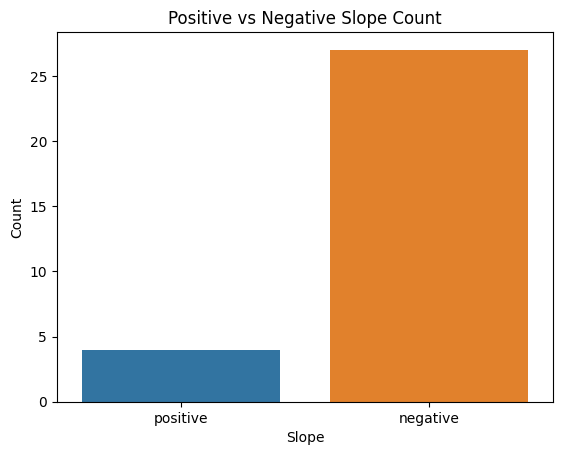

Number of positive slope examples: 4
Number of negative slope examples: 27


In [26]:
# Create a DataFrame
df = pd.DataFrame({
    'Array': ['positive', 'negative'],
    'Length': [len(positive_slopes), len(negative_slopes)]
})

# Create the plot
plot = sns.barplot(x='Array', y='Length', data=df)

# Set the title
plot.set_title('Positive vs Negative Slope Count')

# Set x and y-axis labels
plot.set_xlabel('Slope')
plot.set_ylabel('Count')

plt.show()

print('Number of positive slope examples:',len(positive_slopes))
print('Number of negative slope examples:',len(negative_slopes))

## 31, out of the original 218, groupings showed a statistically significant (p < .10) relationship between year and First_Yes_DOY
##4 have a positive slope
##27 have a negative slope